<img src="img/decisionmaking.png" width=400>

# ELEC-E7851 - Computational User Interface Design
# Lecture 10 - Modeling decision making

**Aurélien Nioche**

Aalto University

---

<div class="alert alert-block alert-success">
<h2><img src="img/goal.png" width=20, align="left">&nbsp;Learning objectives</h2>
    <br>Learn by a basic example the elementary rules of cognitive modeling, including:
    <ul>
        <li>How to design task and models (see <a href="#1.-Task-Model-&-Decision-Making-Models" class="alert-link">Section 1</a>);
        <li>How to conduct exploratory simulations and  (see <a href="#2.-Exploratory-Simulations" class="alert-link">Section 2</a>);
        <li>How to fit your models on experimental data and be confident that you can recover the best parameters (see <a href="#3.-Parameter-Recovery" class="alert-link">Section 3</a>);
        <li>How to compare the quality of your models given data and be confident that you can recover the best model (see <a href="#4.-Model-Recovery" class="alert-link">Section 4</a>);
        <li>How to simulate your experimental results in preparation of a 'real' experiment (see <a href="#5.-Fake-Experiment" class="alert-link">Section 5</a>);
    </ul>
</div>


## Course Overview

<img src="img/design.png" width=30, align="left">&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:2rem; font-weight:bold"><a href="#1.-Task-Model-&-Decision-Making-Models">1. Task Model & Decision Making Models</span></a>

1.1 Task definition

1.2 Models definition


<img src="img/simulation.jpg" width=50, align="left">&nbsp;<span style="font-size:2rem; font-weight:bold"><a href="#2.-Exploratory-Simulations">2. **Exploratory Simulations**</span></a>

2.1 Simulate a single agent

2.2 Analyse latent variables

2.3 Simulate a population of homogeneous agents

2.4 Represent the effect of the free parameters on behavior

<img src="img/optimization.jpeg" width=50, align="left">&nbsp;<span style="font-size:2rem; font-weight:bold"><a href="#3.-Parameter-Recovery">3. Parameter Recovery</span></a>

3.1 Define your likelihood function

3.2 Choose a way to search for the best parameters

3.3 Try with a single agent

3.4 Explore the behavior of the likelihood function over parameter space

3.5 Try with a homogeneous population

3.6 Systematize the approach

<img src="img/competition.png" width=50, align="left">&nbsp;<span style="font-size:2rem; font-weight:bold"><a href="#4.-Model-Recovery">4. Model Recovery</span></a>

4.1 Choose a metric
    
4.2 Try with a single subject

4.3 Systematize the approach

<img src="img/experiment.jpg" width=30, align="left">&nbsp;&nbsp;&nbsp;&nbsp;<span style="font-size:2rem; font-weight:bold"><a href="#5.-Fake-Experiment">5. Fake Experiment</span></a>

---
### Note

This lecture is greatly inspired by <a href="https://www.ocf.berkeley.edu/~acollins/pdfs/papers/WilsonCollins_modelFitting.pdf" >Wilson & Collins (2019) </a>.

---
## Preamble

Import the modules

In [1]:
import numpy as np
import scipy.optimize
import scipy.stats
from itertools import product
from tqdm import tqdm

from utils.decorator import use_pickle
import stats.stats as stats
import plot.plot as plot

## 1. Task Model & Decision Making Models

<img src="img/design.png" width=300>

<div class="alert alert-block alert-success">
<h3><img src="img/goal.png" width=20, align="left">&nbsp;Section Goal</h3>
<ul>
    <li>Design the task that will allow you to answer your research question;
    <li> Design the decision making models that you want to put in competition.
    </ul>
</div>


### 1.1 Task definition

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Check the adequacy with the research question you want to answer;
        <li>Select adequate characteristics (i.e., enough time-steps).
    </ul>
</div>

<img src="img/how_to.png" width=25, align="left">&nbsp;**How to do it?**

Let's take as example:

**Question**

"How do people learn the probabilities of rewards given a pool of options?"

<b>Task: <a href="https://en.wikipedia.org/wiki/Multi-armed_bandit">Bandit task</a></b>

<img src="img/multiarmedbandit.jpg" width=200>

Parameters: 
* Number of option ($N$)
* Distribution of probability over these options ($\{p_{reward}(i)\}_{i\in N}$)
* Number of trials ($T$)


*Note: In lecture 7, you studied how to solve the bandit problem programmatically aiming for the most optimal result. In this class, we don't aim for optimality but seek to understand how humans solve this type of problem.*

In [2]:
N = 2
P = np.array([0.5, 0.75])
T = 500

N_SUBJECTS = 30

### 1.2 Models definition
<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Select/Define which aspect(s) you want to model;
        <li>Model alternatives.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

Here, we will consider that each agent has the opportunity at each $t\in T$ to:
* Choose: we will define for each model a "decision rule", more precisely, we model a probability distribution over the action choices such as:
\begin{equation}
\forall i: p_{choice}(i) \in [0, 1] \wedge \sum_{i}^N p_{choice}(i) = 1  
\end{equation}

* Learn: we will define for each model an "updating rule".

In [3]:
class GenericPlayer:
    
    """
    Generic Player
    """
    
    param_labels = ()
    fit_bounds = ()

    def __init__(self):
        self.options = np.arange(N)

    def choose(self):
        p = self.decision_rule()
        return np.random.choice(self.options, p=p)

    def learn(self, option, success):
        self.updating_rule(option=option, success=success)

    def decision_rule(self):
        raise NotImplementedError

    def updating_rule(self, option, success):
        pass

On this basis, we can define all of our models. Let's begin as simple as possible:


**M1. Random selection**

<img src="img/coin.png" width=200>

* Decision rule:

\begin{equation}
p_{choice}(i) = 1/N
\end{equation}

In [4]:
class Random(GenericPlayer):
    
    """
    Random selection
    """

    def __init__(self):
        super().__init__()

    def decision_rule(self):
        return np.ones(N) / N

<b>M2. <a href="https://en.wikipedia.org/wiki/Win%E2%80%93stay,_lose%E2%80%93switch">Win-Stay-Loose-Switch</a> (Noisy variant)</b>

<img src="img/wsls.png" width=200>

* Decision rule ($\epsilon$)

\begin{equation}
p_{choice}(i) = 
\begin{cases}
1−\epsilon+\epsilon / N &\text{if } r_{t−1} =1 \wedge c_{t−1} = i,\\
\epsilon / N &\text{if } r_{t−1} =1 \wedge c_{t−1} \neq i,\\
\dfrac{1−\epsilon}{N-1} + \epsilon / N & \text {otherwise.}\\
\end{cases}
\end{equation}

In [5]:
class WSLS(GenericPlayer):
    """
    Win-Stay-Lose-Switch
    """

    param_labels = "epsilon",
    fit_bounds = (0., 1),

    def __init__(self, epsilon):
        super().__init__()
        self.epsilon = epsilon

        self.c = -1
        self.r = -1

    def decision_rule(self):

        if self.c == -1:
            return np.ones(N) / N  # First turn

        p = np.zeros(N)

        # 1 - epsilon: select the same
        # epsilon: choose randomly
        # ...so p apply rule
        p_apply_rule = 1 - self.epsilon
        p_random = self.epsilon / N
        if self.r:
            p[self.options != self.c] = p_random
            p[self.c] = 1 - np.sum(p)  # p_apply_rule + p_random
        else:
            p[self.options != self.c] = p_apply_rule / (N - 1) + p_random
            p[self.c] = 1 - np.sum(p)  # p_random

        assert np.sum(p) == 1, \
            f"c: {self.c}; r{self.r}: epsilon:{self.epsilon}; p:{p}; sum p {np.sum(p)}"

        return p

    def updating_rule(self, option, success):
        self.r = success
        self.c = option

<b>M3. <a href="https://en.wikipedia.org/wiki/Rescorla%E2%80%93Wagner_model">Rescorla-Wagner</a></b>

<img src="img/rw_illustration.png" width=400>

* Decision rule ($\beta$)

\begin{equation}
p_{choice}(i) = \dfrac{\exp (\beta Q(i))}{\sum_{j \in N} \exp (\beta Q(j))} 
\end{equation}

* Updating rule ($\alpha$)

\begin{equation}
Q^{t+1}(i) = Q^t(i) + \alpha(s - Q^t(i))
\end{equation}

In [6]:
class RW(GenericPlayer):
    """
    Rescorla-Wagner
    """

    param_labels = r"$\alpha$", r"$\beta$",
    fit_bounds = (0.0, 1.0), (1.0, 20.0),

    def __init__(self, q_alpha, q_beta, initial_value=0.5):
        super().__init__()
        self.q_values = np.full(N, initial_value)
        self.q_alpha = q_alpha
        self.q_beta = q_beta

    def decision_rule(self):
        p_soft = np.exp(self.q_beta * self.q_values) / \
                 np.sum(np.exp(self.q_beta * self.q_values))
        return p_soft

    def updating_rule(self, option, success):
        self.q_values[option] += \
            self.q_alpha * (success - self.q_values[option])

<img src="img/status_quo.jpg" width=400>

**M4. Rescorla-Wagner-Choice-Kernel**

* Decision rule ($\beta_q$, $\beta_c$)

\begin{equation}
p_{choice}(i) = \dfrac{\exp (\beta_q Q(i)+ \beta_c C(i))}{\sum_{j \in N} 
\exp (\beta_q Q(j)+ \beta_c C(j))} 
\end{equation}

* Updating rule ($\alpha$)

\begin{align}
Q^{t+1}(i) &= Q^t(i) + \alpha(s - Q^t(i)) \\
C^{t+1}(i) &= C^t(i) + \alpha(a^t(i) - C^t(i)) \\
\end{align}

where $a^t(i) = 1$ if option $i$ selected at time $t$ else 0.

<i>Note: the implementation follows the description given by <a href="https://www.ocf.berkeley.edu/~acollins/pdfs/papers/WilsonCollins_modelFitting.pdf" >Wilson & Collins (2019) </a>.</i> 

In [7]:
class RWCK(RW):

    """
    Rescorla-Wagner-Choice-Kernel
    """

    param_labels = ("alpha_q", "beta_q", "alpha_c", "beta_c")
    fit_bounds = (0.0, 1), (1.0, 20.0), (0.0, 1), (1.0, 20.0)

    def __init__(self,  q_alpha, q_beta, c_alpha, c_beta):

        super().__init__(q_alpha=q_alpha, q_beta=q_beta)
        self.c_alpha = c_alpha
        self.c_beta = c_beta
        self.c_values = np.zeros(N)

    def decision_rule(self):

        p_soft = np.exp(
            (self.q_beta * self.q_values) +
            (self.c_beta * self.c_values)
        ) / \
             np.sum(np.exp(
                 (self.q_beta * self.q_values) +
                 (self.c_beta * self.c_values)
             ))
        return p_soft

    def updating_rule(self, option, success):

        a = np.zeros(N, dtype=int)
        a[option] = 1

        self.c_values[:] += \
            self.c_alpha * (a - self.c_values[:])

        super().updating_rule(option=option, success=success)

## 2. Exploratory Simulations 

<img src="img/simulation.jpg" width=300>

<div class="alert alert-block alert-danger">
<h3><img src="img/warning.png" width=20, align="left">&nbsp;Warning</h3>
    <br>We will describe the procedure only for Rescorla-Wagner, but it should done for <b>all</b> the models in competition.</div>
    
<div class="alert alert-block alert-success">
<h3><img src="img/goal.png" width=20, align="left">&nbsp;Section Goal</h3>
<ul>
    <li>'Play' with your models;
    <li> Be sure that you obtain at least under some conditions what you want to model;
    <li> Have a general overview of what your results could look like.
    </ul>
</div>

### 2.1 Simulate a single agent

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Have a first insight into the expected behavior;
        <li>Be sure that your metrics for behavior are adapted.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

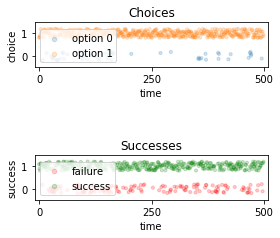

In [8]:
@use_pickle
def run_simulation(seed, agent_model, param=()):

    # Seed the pseudo-random number generator
    np.random.seed(seed)

    # Create the agent
    agent = agent_model(*param)

    # Data containers
    choices = np.zeros(T, dtype=int)
    successes = np.zeros(T, dtype=bool)

    # Simulate the task
    for t in range(T):

        # Determine choice
        choice = agent.choose()

        # Determine success
        p_success = P[choice]
        success = np.random.choice(
            [0, 1],
            p=np.array([1 - p_success, p_success]))

        # Make agent learn
        agent.learn(option=choice, success=success)

        # Backup
        choices[t] = choice
        successes[t] = success

    return choices, successes


# We will experiment with Rescola-Wagner
MODEL_XP = RW

# Get data
SEED_SINGLE = 0
PARAM_SINGLE = np.array([0.10, 10.00])
CHOICES_SINGLE, SUCCESSES_SINGLE = \
    run_simulation(agent_model=MODEL_XP, param=PARAM_SINGLE, seed=SEED_SINGLE)

# Plot
# Begin with the most basic form possible
plot.behavior_single_basic(choices=CHOICES_SINGLE,
                           successes=SUCCESSES_SINGLE)

### 2.2 Analyse latent variables

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Observe dynamics of your model.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

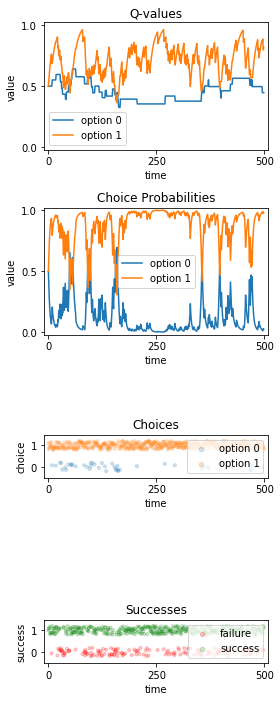

In [9]:
def latent_variables_rw(choices, successes, param):

    """
    Specific to RW
    """

    # Create the agent
    agent = RW(*param)

    # Data containers
    q_values = np.zeros((T, N))
    p_choices = np.zeros((T, N))

    # (Re-)Simulate the task
    for t in range(T):

        # Register values
        q_values[t] = agent.q_values

        # Register probabilities of choices
        p_choices[t] = agent.decision_rule()

        # Make agent learn
        agent.learn(option=choices[t],
                    success=successes[t])

    return q_values, p_choices


# Get the data
Q_VALUES_SINGLE, P_CHOICES_SINGLE = \
    latent_variables_rw(choices=CHOICES_SINGLE,
                        successes=SUCCESSES_SINGLE,
                        param=PARAM_SINGLE)

# Plot
plot.latent_variables_rw_and_behavior_single(q_values=Q_VALUES_SINGLE,
                                             p_choices=P_CHOICES_SINGLE,
                                             choices=CHOICES_SINGLE,
                                             successes=SUCCESSES_SINGLE)


---


### 2.3 Simulate a population of homogeneous agents

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Evaluate the 'noise' of your behavior by using constant parametrisation;
        <li>Get a picture of your expected behavior under the best scenario 
(you find the best model, and subjects share the same best parameters).
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

- Maintain constant the parameters that you are using (except the seed of your pseudo-random number generator)

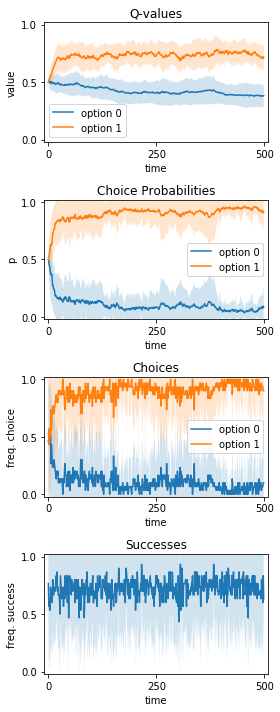

In [10]:
@use_pickle
def run_sim_pop(model, param, n_subjects):

    print(f"Running simulation for {n_subjects} agents...")

    # Data containers
    choices = np.zeros((n_subjects, T), dtype=int)
    successes = np.zeros((n_subjects, T), dtype=bool)

    for i in tqdm(range(n_subjects)):

        # Get choices and successes
        c, s = run_simulation(seed=i,
                              agent_model=model,
                              param=param[i])

        # Backup
        choices[i] = c
        successes[i] = s

    return choices, successes


@use_pickle
def latent_variables_rw_pop(choices, successes, param):

    """
    Specific to RW
    """

    n_subjects = len(choices)

    # Data containers
    q_values = np.zeros((n_subjects, T, N))
    p_choices = np.zeros((n_subjects, T, N))

    for i in range(n_subjects):

        # Get q-values and choice probabilities
        qv, pc = latent_variables_rw(choices=choices[i],
                                     successes=successes[i],
                                     param=param[i])

        # Backup
        q_values[i] = qv
        p_choices[i] = pc

    return q_values, p_choices


# Get the data
PARAM_HOM_POP = [PARAM_SINGLE for _ in range(N_SUBJECTS)]

CHOICES_HOM_POP, SUCCESSES_HOM_POP = \
    run_sim_pop(model=MODEL_XP, param=PARAM_HOM_POP, n_subjects=N_SUBJECTS)

Q_VALUES_HOM_POP, P_CHOICES_HOM_POP = \
    latent_variables_rw_pop(choices=CHOICES_HOM_POP,
                            successes=SUCCESSES_HOM_POP,
                            param=PARAM_HOM_POP)

# Plot
plot.latent_variables_rw_and_behavior_pop(
    q_values=Q_VALUES_HOM_POP, p_choices=P_CHOICES_HOM_POP,
    choices=CHOICES_HOM_POP, successes=SUCCESSES_HOM_POP)


---

### 2.4 Represent the effect of the free parameters on behavior

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Isolate the effect of each parameter;
        <li>Notice dynamics that may differ from initial intuitions (e.g., non linear).
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

In our case, we can:
* Represent the q-values over time for different learning rates ($\alpha$)

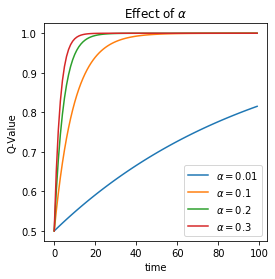

In [11]:
def rw_alpha_effect(param_values, n_iteration=100):

    n_param_values = len(param_values)

    values = np.zeros((n_iteration, n_param_values))

    for i in range(n_param_values):
        agent = RW(
            q_alpha=param_values[i],
            q_beta=None)
        for t in range(n_iteration):

            values[t, i] = agent.q_values[0]
            agent.learn(option=0, success=1)

    return values


# Get data
PARAM_VALUES = (0.01, 0.1, 0.2, 0.3)
Y_VALUES = rw_alpha_effect(PARAM_VALUES)

# Plot
plot.rw_alpha(param_values=PARAM_VALUES, y_values=Y_VALUES)

 ---
 * Represent the probability of choice for an option against another depending on the difference of value, for $\beta$-values

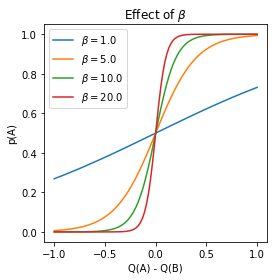

In [12]:
def rw_beta_effect(param_values,
                   min_reward=0,
                   max_reward=1):

    max_diff = max_reward - min_reward
    x_values = np.linspace(-max_diff, max_diff, 100)

    n_x_values = len(x_values)
    n_param_values = len(param_values)

    y_values = np.zeros((len(x_values), n_param_values))

    for i in range(n_param_values):
        for j in range(n_x_values):
            x = x_values[j]
            beta = param_values[i]
            y_values[j, i] = 1 / (1 + np.exp(-beta*x))

    return x_values, y_values


# Get data
PARAM_VALUES = (1.0, 5.0, 10.0, 20.0)
X_VALUES, Y_VALUES = rw_beta_effect(PARAM_VALUES)

# Plot
plot.rw_beta(param_values=PARAM_VALUES,
             x_values=X_VALUES, y_values=Y_VALUES)

---
## 3. Parameter Recovery

<img src="img/optimization.jpeg" width=400>

<div class="alert alert-block alert-danger">
<h3><img src="img/warning.png" width=20, align="left">&nbsp;Warning</h3>
<br>
    You should operate also exploratory simulations (as described in <a class="alert-link" href="#2.-Exploratory-Simulations">Section 2</a>) for <strong>all</strong> the models in competition before proceeding to parameter recovery.</div>

<div class="alert alert-block alert-success">
<h3><img src="img/goal.png" width=20, align="left">&nbsp;Section Goal</h3>
<ul><li>Be sure that you are able to retrieve the parameters of your model, 
    assuming that your model is correct.</ul>
</div>


---
### 3.1 Define a likelihood function


<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
<ul>
    <li>Be able to express numerically the likelihood to have obtained the data given a given model and a specific set of parameters.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;**How to do it?**

* Determine the (log) likelihood of your model:

\begin{equation}
\log p(D \mid M, \theta) = \sum_{d \in D} \log p(d \mid M, \theta)
\end{equation}

*Note: For several reasons (including numerical precision on computers but also easier algebraic manipulation), it is preferable to use the log-likelihood than the likelihood.*

In [13]:
def log_likelihood(model, param, choices, successes):

    # Create the agent
    agent = model(*param)

    # Data container
    ll = np.zeros(T)

    # Simulate the task
    for t in range(T):

        # Get choice and success for t
        c, s = choices[t], successes[t]

        # Look at probability of choice
        p_choice = agent.decision_rule()
        p = p_choice[c]

        # Compute log
        ll[t] = np.log(p + np.finfo(np.float).eps)

        # Make agent learn
        agent.learn(option=c, success=s)

    return np.sum(ll)

### 3.2 Choose a way to search for the best parameters


<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
<ul><li>Identify a method that allows you to 'easily' identify 
    the best-fit parameters for each of your models.</ul>
<br><i>Note: parameter space can be extremly&mdash;infinitely&mdash;large, so it is impossible to compute all the possibilities: you need to select which are the most interesting set of parameters to test.</i>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;**How to do it?**

<i>Note: In lecture 6, you saw how to use Bayesian optimization. Here, we will use the <a href="https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html">function 'minimize' from the SciPy package</a>.</i> 

In [14]:
class BanditOptimizer:

    """
    Given a series of choices and successes, and a DM model,
    estimate the best-fit param
    """

    def __init__(self, choices, successes, model):

        self.choices = choices
        self.successes = successes
        self.model = model

        assert hasattr(model, 'fit_bounds'), \
            f"{model.__name__} has not 'fit_bounds' attribute"

        self.t = 0

    def objective(self, param):
        return - log_likelihood(model=self.model,
                                choices=self.choices,
                                successes=self.successes,
                                param=param)

    def run(self):

        if self.model.fit_bounds:
            res = scipy.optimize.minimize(
                fun=self.objective,
                x0=np.array([(b[1] - b[0])/2 for b in self.model.fit_bounds]),
                bounds=self.model.fit_bounds)
            assert res.success

            best_param = res.x
            best_value = res.fun

        else:
            assert self.model == Random
            best_param = ()
            best_value = self.objective(())

        return best_param, best_value

### 3.3 Try with a single agent

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>

<ul><li>Be sure that in the simplest case (single subject), 
you retrieve close enough parameters.
    </ul>
    <br><i>Note: At this stage, you will just rely on an intuitive appreciation. A systematized approach is provided at <a href="#3.6-Systematize-the-process" >the end of this section</a>.</i>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

In [15]:
@use_pickle
def get_best_param():

    # Create optimizer
    opt = BanditOptimizer(
        choices=CHOICES_SINGLE,
        successes=SUCCESSES_SINGLE,
        model=RW
    )

    # Run the optimization
    best_param, best_value = opt.run()
    return best_param


# Get the best-fit parameters
BEST_PARAM_SINGLE = get_best_param()
print(f"'True' parameters: {tuple(PARAM_SINGLE)}")
print(f"Best-fit parameters: {tuple(BEST_PARAM_SINGLE)}\n")

'True' parameters: (0.1, 10.0)
Best-fit parameters: (0.09144770878290102, 10.947370614002782)



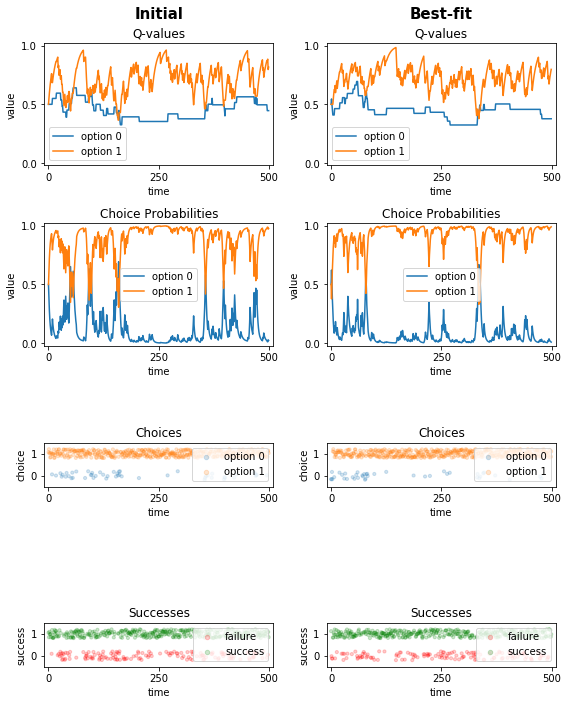

In [16]:
# New simulation with best-fit parameters
CHOICES_SINGLE_BF, SUCCESSES_FIST_BF = \
    run_simulation(seed=SEED_SINGLE + 1, agent_model=RW,
                   param=BEST_PARAM_SINGLE)

# Get the values of the latent variables
Q_VALUES_SINGLE_BF, P_CHOICES_SINGLE_BF = \
    latent_variables_rw(choices=CHOICES_SINGLE_BF,
                        successes=SUCCESSES_FIST_BF,
                        param=BEST_PARAM_SINGLE)

# Plot
plot.comparison_best_fit_rw_single(
    q_values=Q_VALUES_SINGLE, p_choices=P_CHOICES_SINGLE,
    choices=CHOICES_SINGLE, successes=SUCCESSES_SINGLE,
    choices_bf=CHOICES_SINGLE_BF, successes_bf=SUCCESSES_FIST_BF,
    q_values_bf=Q_VALUES_SINGLE_BF, p_choices_bf=P_CHOICES_SINGLE_BF)


### 3.4 Explore the behavior of the likelihood function over the parameter space

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Observe the behavior of your likelihood function over the parameter space;
        <li>Notify the local minima.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

* Represent the objective function values over the parameter space (phase diagram)

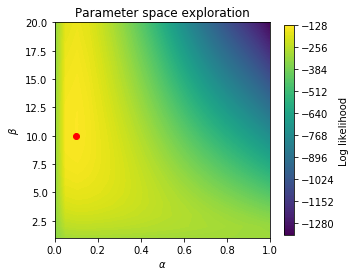

In [17]:
@use_pickle
def parameter_space_exploration(model, choices, successes, grid_size=20):

    """
    Compute likelihood for several combinations of parameters
    (using grid exploration)
    """

    print("Computing data for parameter space exploration...")

    assert len(model.param_labels) == 2, \
        "this function is designed for models that have " \
        "at least and at most 2 parameters"
    assert hasattr(model, 'fit_bounds'), \
        f"{model.__name__} has not 'fit_bounds' attribute"

    n_param = len(model.fit_bounds)

    parameter_values = np.atleast_2d([
                np.linspace(
                    *model.fit_bounds[i],
                    grid_size) for i in range(n_param)
    ])

    # Create a grid for each parameter
    param_grid = np.asarray(list(
            product(*parameter_values)
        ))

    n_sets = len(param_grid)

    # Container for log-likelihood
    ll = np.zeros(n_sets)

    # Loop over each value of the parameter grid for both parameters
    for i in tqdm(range(n_sets)):

        # Select the parameter to use
        param_to_use = param_grid[i]

        # Call the objective function of the optimizer
        ll[i] = log_likelihood(
            choices=choices,
            successes=successes,
            model=model,
            param=param_to_use)

    return parameter_values, ll


# Get data
PARAM_VALUES, LL = parameter_space_exploration(
    model=RW,
    choices=CHOICES_SINGLE,
    successes=SUCCESSES_SINGLE)


# Plot phase diagram
plot.parameter_space_exploration_2d(
    data=LL,
    parameter_values=PARAM_VALUES,
    param_names=RW.param_labels,
    true_params=PARAM_SINGLE,
    title='Parameter space exploration')

<div class="alert alert-block alert-danger">
<h2><img src="img/warning.png" width=20, align="left">&nbsp;Warning</h2>
    <br>This solution only works if your model has two parameters. For a model having only one parameter, you can represent it by a single curve of the log-likelihood against the parameter value (you can refer to the <a href="#S2.-Parameter-space-exploration" class="alert-link">supplementary</a> for that). For more than two parameters, things get more complicated: you can still do one plot per parameter as shown in the <a href="#S2.-Parameter-space-exploration" class="alert-link">supplementary</a> for the present case, but the interpretation is not always easy.</div>


### 3.5 Try with a homogeneous population

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Generalize what you observe with a single subject to a homogeneous population.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

- Maintain constant the parameters that you are using (except the seed of your pseudo-random number generator)

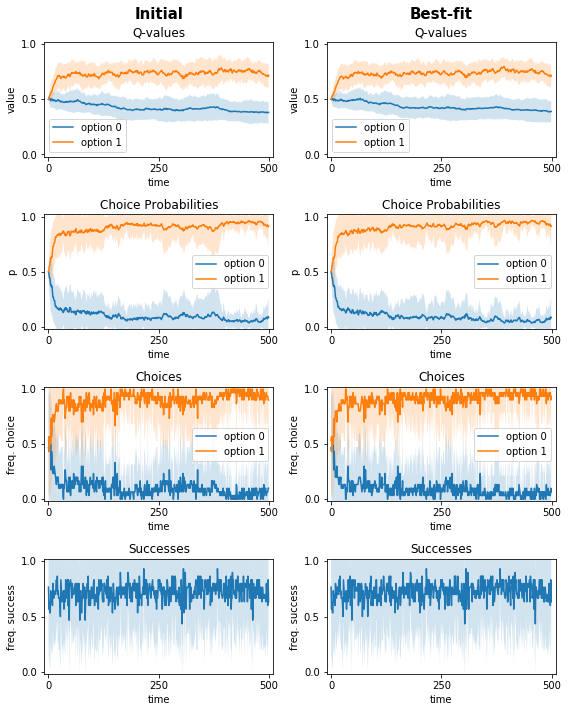

In [18]:
# Define as parameter the best-fit parameter for the single agent
PARAM_HOM_POP_BF = [BEST_PARAM_SINGLE for _ in range(N_SUBJECTS)]

# Get behavior for best-fit
CHOICES_HOM_POP_BF, SUCCESSES_HOM_POP_BF = \
    run_sim_pop(model=RW, param=PARAM_HOM_POP_BF, n_subjects=N_SUBJECTS)

# Get latent variables values
Q_VALUES_HOM_POP_BF, P_CHOICES_HOM_POP_BF = \
    latent_variables_rw_pop(choices=CHOICES_HOM_POP_BF,
                            successes=SUCCESSES_HOM_POP_BF,
                            param=PARAM_HOM_POP_BF)

# Plot
plot.comparison_best_fit_rw_pop(
    choices=CHOICES_HOM_POP, choices_bf=CHOICES_HOM_POP_BF,
    successes=SUCCESSES_HOM_POP, successes_bf=SUCCESSES_HOM_POP_BF,
    q_values=Q_VALUES_HOM_POP, q_values_bf=Q_VALUES_HOM_POP_BF,
    p_choices=P_CHOICES_HOM_POP, p_choices_bf=P_CHOICES_HOM_POP_BF
)

*Highlight only qualitative interpretation*

### 3.6 Systematize the process

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Test parameter recovery for a large (enough) set of parameters;
        <li>Have a metric of the quality of your parameter recovery (Pearson's r), including statistical assessment of the relevancy.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

* Represent the parameters used to simulate against the parameters recovered:

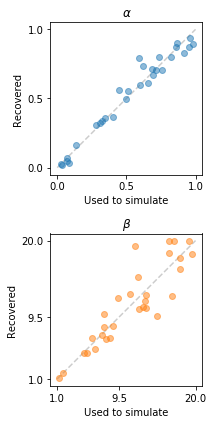

In [19]:
@use_pickle
def data_param_recovery(model, n_sets, seed):

    print("Computing data for parameter recovery...")

    # Seed the random number generator
    np.random.seed(seed)

    # Get the parameters labels
    param_labels = model.param_labels
    n_param = len(param_labels)

    # Data container (2: simulated, retrieved)
    param = np.zeros((n_param, 2, n_sets))

    # Loop over the number of parameter sets
    for set_idx in tqdm(range(n_sets)):

        # Select parameter to simulate...
        param_to_sim = \
            [np.random.uniform(*b)
             for b in model.fit_bounds]

        # Simulate
        choices, successes = run_simulation(seed=set_idx,
                                            agent_model=model,
                                            param=param_to_sim)

        # Create the optimizer and run it
        opt = BanditOptimizer(choices=choices,
                              successes=successes,
                              model=model)
        best_param, best_value = opt.run()

        # Backup
        for i in range(n_param):
            param[i, 0, set_idx] = param_to_sim[i]
            param[i, 1, set_idx] = best_param[i]

    return param


# Get data
P_RCV = data_param_recovery(model=RW, n_sets=30, seed=234)

# Plot
plot.parameter_recovery(data=P_RCV,
                        param_names=RW.param_labels,
                        param_bounds=RW.fit_bounds)

Compute the Pearson's coefficient for each model parameter, and assess the stastistical relevance:

In [20]:
# Stats
stats.correlation_recovery(data=P_RCV, param_names=RW.param_labels)


Statistical analysis for the parameter recovery

[$\alpha$] cor=0.980, p<0.001 *
[$\beta$] cor=0.895, p<0.001 *




## 4. Model Recovery

<img src="img/competition.png" width=400>


<div class="alert alert-block alert-danger">
<h3><img src="img/warning.png" width=20, align="left">&nbsp;Warning</h3>
    <br>You should operate the process for parameter recovery (as described in <a class="alert-link" href="#3.-Parameter-Recovery">Section 3</a>) for <strong>all</strong> the models in competition before proceeding to model recovery.</div>
    
<div class="alert alert-block alert-success">
<h3><img src="img/goal.png" width=20, align="left">&nbsp;Section Goal</h3>
<ul><li>Ensure that each model, when used for simulating, is selected as the best model.</ul>
</div>

### 4.1 Choose a metric

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Choose a metric to compare your models.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

* Before all, define your model space. Here, we will compare:
    * Random selection
    * Win-Stay-Lose-Switch
    * Rescola-Wagner
    * Rescola-Wagner-Choice-Kernel

In [21]:
MODELS = Random, WSLS, RW, RWCK
MODEL_NAMES = [m.__name__ for m in MODELS]

* Then choose a metric to compare your models. Here, we will use the Bayesian Information Criterion (BIC):
\begin{equation}
\text{BIC} = - 2 \log p(D\mid {\widehat {\theta }},M) + k \log(T)
\end{equation}

*Note: the lowest the BIC score is, the best it is*


In [22]:
def bic(ll, k, n_iteration):
    return -2 * ll + k * np.log(n_iteration)

* Write a function that allows you, based on a list of choices and successes, to compute the metric for each model:

In [23]:
@use_pickle
def optimize_and_compare_single(choices, successes):

    n_models = len(MODELS)
    bic_scores = np.zeros(n_models)
    lls = np.zeros(n_models)
    best_params = []

    for j in range(n_models):

        # Select the model
        model_to_fit = MODELS[j]

        # Create the optimizer and run it
        opt = BanditOptimizer(choices=choices,
                              successes=successes,
                              model=model_to_fit)
        best_param, best_value = opt.run()

        # Get log-likelihood for best param
        ll = -best_value

        # Compute the bit score
        bs = bic(ll, k=len(model_to_fit.fit_bounds), n_iteration=T)

        # Backup
        bic_scores[j] = bs
        lls[j] = ll
        best_params.append(best_param)

    return best_params, lls, bic_scores

### 4.2 Try with a single agent

<div class="alert alert-block alert-danger">
<h3><img src="img/warning.png" width=20, align="left">&nbsp;Warning</h3>
<br>
    You should operate this process for <b>all</b> the models in competition (not only for one, even if you think it is the best one).</div>
   
<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Check that everything is going fine in the most simple case.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

In [24]:
def comparison_single_subject():

    best_params, lls, bic_scores = \
        optimize_and_compare_single(
            choices=CHOICES_SINGLE, successes=SUCCESSES_SINGLE)

    print(f"Model used: {MODEL_XP.__name__}")
    print("-" * 10)

    for i in range(len(MODELS)):
        print(f"BIC {MODELS[i].__name__} = {bic_scores[i]:.3f}")

    print()


# Compute bic scores for evey model for our initial set of data
comparison_single_subject()

Model used: RW
----------
BIC Random = 693.147
BIC WSLS = 598.003
BIC RW = 281.243
BIC RWCK = 294.216



### 4.3 Systematize the approach

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Test that you can generalize what you observed with one single individual;
        <li>Have a metric of the quality of your model recovery.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

* Draw a confusion matrix:

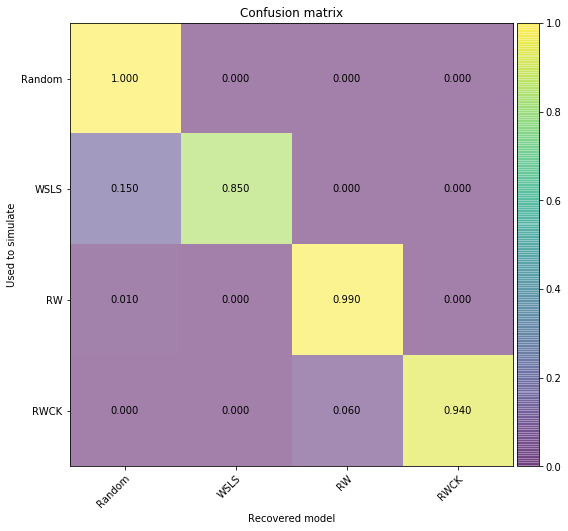

In [25]:
@use_pickle
def data_confusion_matrix(models, n_sets):

    print("Computing data for confusion matrix...")

    # Number of models
    n_models = len(models)

    # Data container
    confusion_matrix = np.zeros((n_models, n_models))

    # Loop over each model
    with tqdm(total=n_models*n_sets) as pbar:
        for i in range(n_models):

            # Select the model
            model_to_sim = models[i]

            for j in range(n_sets):

                # Select parameters to simulate
                param_to_sim = \
                    [np.random.uniform(*b)
                     for b in model_to_sim.fit_bounds]

                # Simulate
                choices, successes = \
                    run_simulation(
                        seed=j,
                        agent_model=model_to_sim,
                        param=param_to_sim)

                # Compute bic scores
                best_params, lls, bic_scores = \
                    optimize_and_compare_single(choices=choices,
                                                successes=successes)

                # Get minimum value for bic (min => best)
                min_ = np.min(bic_scores)

                # Get index of models that get best bic
                idx_min = np.arange(n_models)[bic_scores == min_]

                # Add result in matrix
                confusion_matrix[i, idx_min] += 1/len(idx_min)
                
                # Update progress bar
                pbar.update(1)

    return confusion_matrix


# Data
N_SETS_CONF = 100
SEED_CONF = 123
np.random.seed(SEED_CONF)
CONF_MT = data_confusion_matrix(models=MODELS, n_sets=N_SETS_CONF)

# Plot
plot.confusion_matrix(data=CONF_MT, tick_labels=MODEL_NAMES)

In [26]:
# Stats
stats.classification(CONF_MT, model_names=MODEL_NAMES)


Statistic analysis for the classification

Random
----------
Precision: 1.000, CI=[1.000, 1.000]
Recall: 0.862, CI=[0.799, 0.925]
F1 score = 0.926

WSLS
----------
Precision: 0.850, CI=[0.780, 0.920]
Recall: 1.000, CI=[1.000, 1.000]
F1 score = 0.919

RW
----------
Precision: 0.990, CI=[0.970, 1.000]
Recall: 0.943, CI=[0.898, 0.987]
F1 score = 0.966

RWCK
----------
Precision: 0.940, CI=[0.893, 0.987]
Recall: 1.000, CI=[1.000, 1.000]
F1 score = 0.969



<img src="img/precisionrecall.png" width=300>

## 5. Fake Experiment

<img src="img/experiment.jpg" width=300>

<div class="alert alert-block alert-danger">
<h3><img src="img/warning.png" width=20, align="left">&nbsp;Warning</h3>
    <ul>
        <li>You should operate the process for model recovery (as described in <a class="alert-link" href="#4.-Model-Recovery">Section 4</a>) for <strong>all</strong> the models in competition before 'faking' actual experiments.
        <li> You should conduct 'fake' experiments with <strong>all</strong> the models in competition, even if here, we will conduct an experiment only with the Rescorla-Wagner model. 
    </ul>
</div>



<div class="alert alert-block alert-success">
<h3><img src="img/goal.png" width=20, align="left">&nbsp;Section Goal</h3>
    <ul>
    <li>Have an overview about what the results of your experiment could look like, under the assumption that you get the best model, but that there are small variations in the population in terms of parametrization;
    <li> Ensure that the metrics of your behavior is adapted;
    <li> Be sure that you can retrieve the model in this context;
    <li> Have an idea about the distribution of your metrics regarding model selection (log-likelihood sums, BIC);
    <li> More generally, it is your last resort before the actual experiment (user study) to avoid bad surprises!
    </ul>
</div>

### 5.1 Generate data

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Generate data with a population of (relatively enough) heterogenous agents.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

  0%|          | 0/30 [00:00<?, ?it/s]

Running simulation for 30 agents...


100%|██████████| 30/30 [00:03<00:00,  7.56it/s]


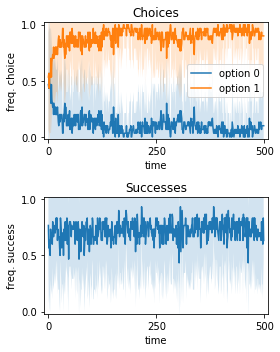

In [27]:
# Get data
SEED_HET_POP = 1234
np.random.seed(SEED_HET_POP)

# Let's assume a normal distribution of the parameters in the population
RW_HET_POP_DIST_PARAM = (0.1, 0.05), (10.0, 0.5)
PARAM_HET_POP = \
    [
        [np.random.normal(*p) for p in RW_HET_POP_DIST_PARAM]
        for _ in range(N_SUBJECTS)
    ]

CHOICES_HET_POP, SUCCESSES_HET_POP = \
    run_sim_pop(model=MODEL_XP, n_subjects=N_SUBJECTS, param=PARAM_HET_POP)

# Plot behavior
plot.behavior_pop(choices=CHOICES_HET_POP, successes=SUCCESSES_HET_POP,
                  n_option=N)

### 5.2 Compare the models

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li> Being sure that in the 'true' context of the experiment, you are able to retrieve the 'best' model.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

* Plot the distributions of the likelihoods and your  model comparison metric for each model, as well as the frequency with which each model is the most likely and the 'best' based on your metric.

100%|██████████| 30/30 [02:06<00:00,  4.22s/it]


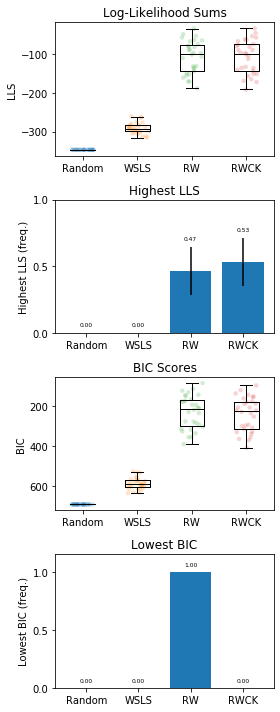

In [28]:
@use_pickle
def optimize_and_compare_pop(choices, successes):

    n_subjects = len(choices)

    # Data containers
    best_parameters = np.zeros(n_subjects, dtype=object)
    lls = np.zeros((n_subjects, len(MODELS)))
    bic_scores = np.zeros((n_subjects, len(MODELS)))

    # Loop over subjects
    for i in tqdm(range(n_subjects)):

        # Optimize and compare
        best_parameters[i], lls[i], bic_scores[i] = \
            optimize_and_compare_single(choices=choices[i],
                                        successes=successes[i])

    # Freq and confidence intervals for the barplot
    lls_freq, lls_err = stats.freq_and_err(lls)
    bic_freq, bic_err = stats.freq_and_err(-bic_scores)

    return lls, lls_freq, lls_err,\
        bic_scores, bic_freq, bic_err, \
        best_parameters


# Get data
LLS_HET, LLS_FREQ_HET, LLS_ERR_HET, \
    BIC_HET, BIC_FQ_HT, BIC_ERR_HET,\
    PARAM_HET_BF = \
    optimize_and_compare_pop(choices=CHOICES_HET_POP,
                             successes=SUCCESSES_HET_POP)

# Plot
plot.model_comparison(
    lls=LLS_HET,
    lls_freq=LLS_FREQ_HET,
    lls_err=LLS_ERR_HET,
    bic_scores=BIC_HET,
    bic_freq=BIC_FQ_HT,
    bic_err=BIC_ERR_HET,
    model_names=MODEL_NAMES
)

* Is the model that you used to simulate selected as the best model?

In [29]:
# Look at the best model
BEST_MODEL_IDX = int(np.argmax(BIC_FQ_HT))
BEST_MODEL = MODELS[BEST_MODEL_IDX]

# Assume that it should be the one that you used to simulate
assert MODEL_XP == BEST_MODEL

### 5.3 Study the distribution of your best-fit parameters

<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Have an insight about how your distribution of best-fit parameters should look like.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

* Plot the distribution of your best-fit parameters:

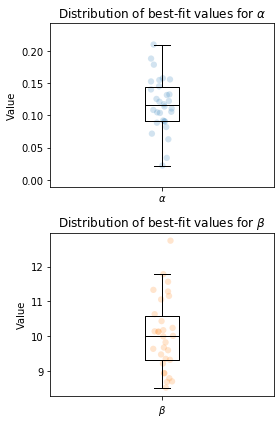

In [30]:
# Retrieve parameters for best model
PARAM_HET_BF_BEST_MODEL = np.asarray(
    [
        PARAM_HET_BF[i][BEST_MODEL_IDX]
        for i in range(N_SUBJECTS)
    ])

# Plot best parameters distribution
plot.distribution_best_parameters(PARAM_HET_BF_BEST_MODEL,
                                  parameter_names=MODEL_XP.param_labels)

### 5.4 Simulate with the best-fit parameters


<div class="alert alert-block alert-info">
<h4><img src="img/goal.png" width=20, align="left">&nbsp;Goal</h4>
    <ul>
        <li>Be sure that in the 'true' context of your experiment, you are able to reproduce the behavior.
    </ul>
</div>

<img src="img/how_to.png" width=20, align="left">&nbsp;<b>How to do it?</b>

  7%|▋         | 2/30 [00:00<00:02, 13.11it/s]

Running simulation for 30 agents...


100%|██████████| 30/30 [00:02<00:00, 13.57it/s]


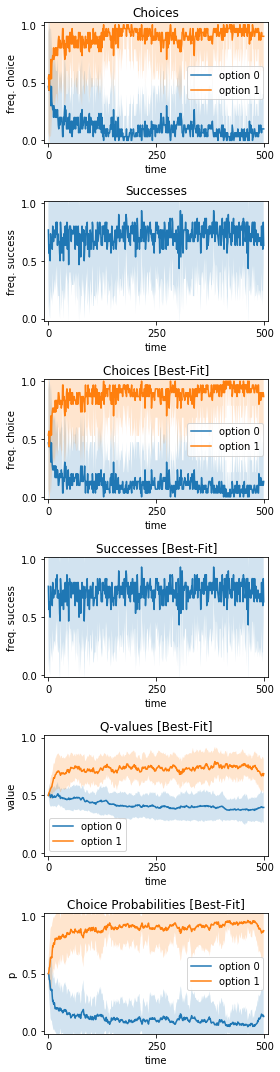

In [31]:
# Get behavior for best-fit
CHOICES_HET_BF, SUCCESSES_HET_BF = \
    run_sim_pop(model=BEST_MODEL, param=PARAM_HET_BF_BEST_MODEL, 
                n_subjects=N_SUBJECTS)

# Get latent variables values
Q_VALUES_HET_BF, P_CHOICES_HET_BF = \
    latent_variables_rw_pop(choices=CHOICES_HET_BF,
                            successes=SUCCESSES_HET_BF,
                            param=PARAM_HET_BF_BEST_MODEL)

plot.post_hoc_sim(
    choices=CHOICES_HET_POP,
    successes=SUCCESSES_HET_POP,
    choices_bf=CHOICES_HET_BF,
    successes_bf=SUCCESSES_HET_BF,
    q_values_bf=Q_VALUES_HET_BF,
    p_choices_bf=P_CHOICES_HET_BF
)

**What do do next?**

Experiment with living agents!

---

## Additional material

<a id='sup_bhv'></a>
### S1. Behavior visualization

* Average individual behavior

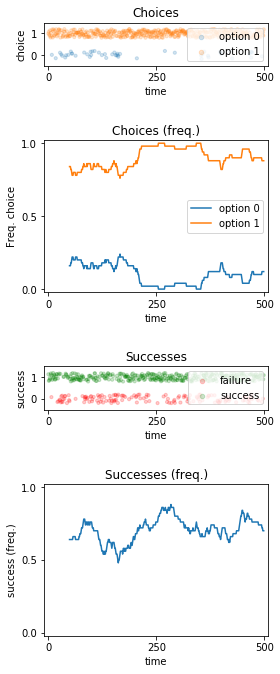

In [32]:
# Plot averate behavior
plot.behavior_single_average(choices=CHOICES_SINGLE,
                             successes=SUCCESSES_SINGLE)

<a id='sup_parameter_space_exploration'></a>

### S2. Parameter space exploration

* Separate plot for each parameter

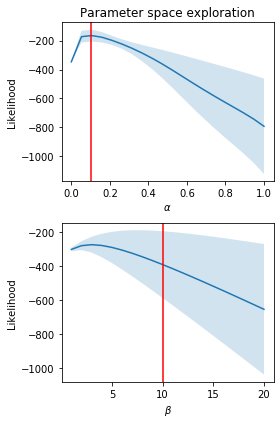

In [34]:
# Separate plot for each parameter
plot.parameter_space_exploration(
    data=LL,
    param_names=RW.param_labels,
    true_params=PARAM_SINGLE,
    parameter_values=PARAM_VALUES,
)